<a href="https://colab.research.google.com/github/AnkitRajSri/FacialEmotionAI/blob/main/FacialExpressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the dependencies and the dataset

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [59]:
import os
import pandas as pd
import numpy as np
import PIL
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
%cd /content/drive/MyDrive/Emotion AI

/content/drive/MyDrive/Emotion AI


In [5]:
facial_expression_df = pd.read_csv("Emotion AI Dataset/icml_face_data.csv")

In [6]:
facial_expression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


### Data Exploration

In [7]:
facial_expression_df.loc[0, " pixels"]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [8]:
facial_expression_df.columns = facial_expression_df.columns.str.replace(" ", "")
facial_expression_df.columns

Index(['emotion', 'pixels'], dtype='object')

##### Fix the pixels column

In [9]:
# Convert the string column to arrays
def string_to_array(x):
  return np.array(x.split(" ")).reshape(48, 48, 1).astype("float32")

# Resize the images to (96, 96)
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

In [10]:
facial_expression_df["pixels"] = facial_expression_df["pixels"].apply(string_to_array)
facial_expression_df["pixels"] = facial_expression_df["pixels"].apply(resize)

In [11]:
facial_expression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [12]:
facial_expression_df.shape

(24568, 2)

In [13]:
facial_expression_df.isna().sum()

emotion    0
pixels     0
dtype: int64

In [14]:
# Create a dictionary of emotions
label_to_text = {0: "anger", 1: "disgust", 2: "sad", 3: "happiness", 4: "surprise"}

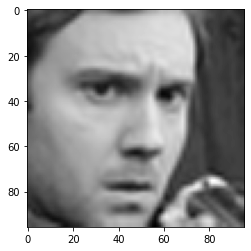

In [15]:
plt.imshow(facial_expression_df["pixels"][0], cmap="gray")

### Image Visualization and Label Plots

In [16]:
emotions = list(label_to_text.keys())
emotions

[0, 1, 2, 3, 4]

In [17]:
facial_expression_df[facial_expression_df["emotion"]==0].head(1)["pixels"].item()

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

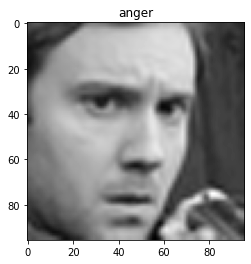

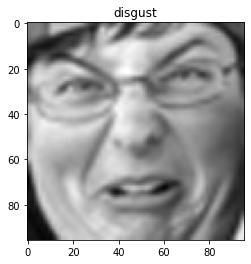

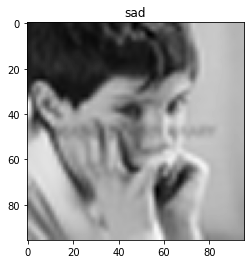

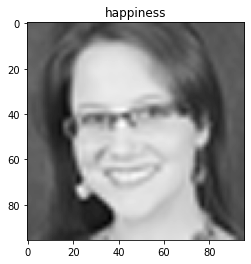

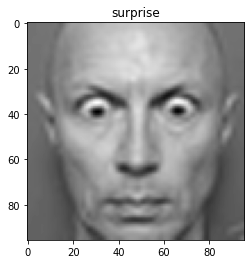

In [18]:
# Let's visualize one image per emotion
for emotion in emotions:
  df = facial_expression_df[facial_expression_df["emotion"]==emotion].head(1)
  img = df["pixels"].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[emotion])
  plt.imshow(img, cmap="gray")

##### Number of images in each emotion

In [19]:
emotion_dist = pd.DataFrame(facial_expression_df["emotion"].value_counts()).reset_index()
emotion_dist.columns = ["emotion", "count"]

In [20]:
fig = px.bar(emotion_dist, x="emotion", y="count", title="Number of images in each emotion")
fig.show()

### Image Augmentation and Data Preparation

##### Split the data into features and labels

In [21]:
X = facial_expression_df["pixels"]
y = keras.utils.to_categorical(facial_expression_df["emotion"])

In [22]:
X, y

(0        [[69.316925, 73.03865, 79.13719, 84.17186, 85....
 1        [[151.09435, 150.91393, 150.65791, 148.96367, ...
 2        [[23.061905, 25.50914, 29.47847, 33.99843, 36....
 3        [[20.083221, 19.079437, 17.398712, 17.158691, ...
 4        [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...
                                ...                        
 24563    [[-4.901001, 5.6496277, 22.477203, 49.366516, ...
 24564    [[181.71645, 179.72063, 176.40785, 175.93037, ...
 24565    [[178.1166, 176.83118, 174.74146, 172.61276, 1...
 24566    [[16.883408, 16.953583, 17.081573, 16.53476, 1...
 24567    [[30.199814, 29.574478, 28.545822, 27.846603, ...
 Name: pixels, Length: 24568, dtype: object, array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]], dtype=float32))

In [23]:
X = np.stack(X, axis=0)
X

array([[[ 6.93169250e+01,  7.30386505e+01,  7.91371918e+01, ...,
          4.07361908e+01,  4.06584015e+01,  4.05393982e+01],
        [ 6.86632538e+01,  7.09522400e+01,  7.47176819e+01, ...,
          4.32747650e+01,  4.20371857e+01,  4.12236176e+01],
        [ 6.77688141e+01,  6.77164612e+01,  6.76717224e+01, ...,
          4.73947296e+01,  4.42632904e+01,  4.23146515e+01],
        ...,
        [ 7.48902130e+01,  7.67955322e+01,  7.99025879e+01, ...,
          7.14634247e+01,  5.93287506e+01,  5.17473602e+01],
        [ 7.66812592e+01,  7.58081055e+01,  7.42545166e+01, ...,
          9.39433746e+01,  7.97793427e+01,  7.11324615e+01],
        [ 7.76385803e+01,  7.51507416e+01,  7.08845978e+01, ...,
          1.07663513e+02,  9.22321167e+01,  8.29158478e+01]],

       [[ 1.51094345e+02,  1.50913925e+02,  1.50657913e+02, ...,
          1.36052124e+02,  1.23477661e+02,  1.15919678e+02],
        [ 1.51136780e+02,  1.50793930e+02,  1.50260208e+02, ...,
          1.38304214e+02,  1.27916794e

In [24]:
length = len(X)
X = X.reshape(length, 96, 96, 1)
print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [25]:
X = X / 255.

##### Train, test, validation split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, shuffle=True)

In [27]:
print("Shape of the training data: ")
print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))

Shape of the training data: 
X_train shape: (22111, 96, 96, 1), y_train shape: (22111, 5)


##### Image Preprocessing and Augmentation

In [28]:
# X_train = X_train/255.
# X_val   = X_val/255.
# X_test  = X_test/255.

In [29]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

### Deep ResNet Architecture

##### Building the model

In [30]:
def res_block(X, filter, stage):

  # Convolutional block
  X_copy = X

  f1, f2, f3 = filter

  # Main path
  X = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_conv_a", kernel_initializer=glorot_uniform(seed=0))(X)
  X = MaxPool2D((2, 2))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_a")(X)
  X = Activation("relu")(X)

  X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding="same", name="res_"+str(stage)+"_conv_b", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_b")(X)
  X = Activation("relu")(X)

  X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_'+str(stage)+'_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis =3, name='bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"conv_copy", kernel_initializer=glorot_uniform(seed=0))(X_copy)
  X_copy = MaxPool2D((2, 2))(X_copy)
  X_copy = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_copy")(X_copy)

  # Add both the paths
  X = Add()([X, X_copy])
  X = Activation("relu")(X)

  # Identity block 1
  X_copy = X

  # Main path
  X = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_1a", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_1a")(X)
  X = Activation("relu")(X)

  X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding="same", name="res_"+str(stage)+"_identity_1b", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_1b")(X)
  X = Activation("relu")(X)

  X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_1c", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_1c")(X)
  X = Activation("relu")(X)

  # Add both the paths
  X = Add()([X, X_copy])
  X = Activation("relu")(X)

  # Identity block 2
  X_copy = X

  # Main path
  X = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_2a", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_2a")(X)
  X = Activation("relu")(X)

  X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding="same", name="res_"+str(stage)+"_identity_2b", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_2b")(X)
  X = Activation("relu")(X)

  X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_2c", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_2c")(X)
  X = Activation("relu")(X)

  # Add both the paths
  X = Add()([X, X_copy])
  X = Activation("relu")(X)

  return X

In [31]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# Stage 2
X = res_block(X, filter= [64, 64, 256], stage= 2)

# Stage 3
X = res_block(X, filter= [128, 128, 512], stage= 3)

#Stage 4
X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation="relu")(X)
X = Dropout(0.20)(X)
X = Dense(2048, activation="relu")(X)
X = Dropout(0.20)(X)
X = Dense(1024, activation="relu")(X)
X = Dropout(0.15)(X)
X = Dense(5, activation="softmax", name="Dense_final", kernel_initializer= glorot_uniform(seed=0))(X)

facialexpression_model = Model(inputs=X_input, outputs=X, name="facialexpression_resnet")

facialexpression_model.summary()

Model: "facialexpression_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________

##### Compile and train the model

In [32]:
# adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
facialexpression_model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
es = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20)
mcp = ModelCheckpoint(filepath="best_facialexpression_weights.hdf5", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

In [34]:
history = facialexpression_model.fit(train_datagen.flow(X_train, y_train, batch_size=32),	validation_data=(X_val, y_val), steps_per_epoch=len(X_train)//32,	epochs=50, callbacks=[mcp, es])

Epoch 1/50
690/690 [==============================] - 36s 37ms/step - loss: 1.9578 - accuracy: 0.3459 - val_loss: 1.5407 - val_accuracy: 0.3721

Epoch 00001: val_accuracy improved from -inf to 0.37215, saving model to best_facialexpression_weights.hdf5
Epoch 2/50
690/690 [==============================] - 25s 36ms/step - loss: 1.2943 - accuracy: 0.4347 - val_loss: 1.3631 - val_accuracy: 0.3852

Epoch 00002: val_accuracy improved from 0.37215 to 0.38518, saving model to best_facialexpression_weights.hdf5
Epoch 3/50
690/690 [==============================] - 25s 36ms/step - loss: 1.1620 - accuracy: 0.5171 - val_loss: 1.1864 - val_accuracy: 0.4731

Epoch 00003: val_accuracy improved from 0.38518 to 0.47313, saving model to best_facialexpression_weights.hdf5
Epoch 4/50
690/690 [==============================] - 25s 36ms/step - loss: 1.0682 - accuracy: 0.5735 - val_loss: 1.2220 - val_accuracy: 0.4577

Epoch 00004: val_accuracy did not improve from 0.47313
Epoch 5/50
690/690 [===============

In [45]:
# Save the model architecture as a json file
model_json = facialexpression_model.to_json()
with open("facialexpression_model.json", "w") as json_file:
  json_file.write(model_json)

### Model Evaluation

##### Accuracy and Loss

In [46]:
# Evaluate the default model
result = facialexpression_model.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

39/39 [==============================] - 0s 11ms/step - loss: 0.9838 - accuracy: 0.6029
Accuracy : 0.6029292345046997


In [47]:
with open("facialexpression_model.json", "r") as json_file:
    json_saved_model= json_file.read()
best_model = models.model_from_json(json_saved_model)
best_model.summary()

In [48]:
best_model.load_weights("best_facialexpression_weights.hdf5")
best_model.compile(loss="categorical_crossentropy", optimizer= "Adam" , metrics = ["accuracy"])

In [39]:
# Evaluate the best model
result = best_model.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

39/39 [==============================] - 1s 11ms/step - loss: 0.6379 - accuracy: 0.7580
Accuracy : 0.7607811093330383


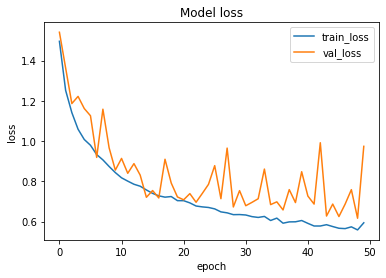

In [49]:
# Plot the training artifacts
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

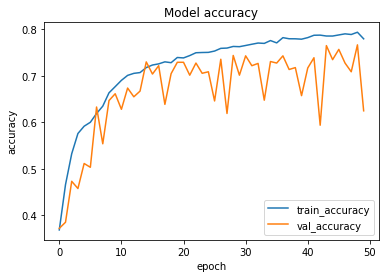

In [50]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'lower right')
plt.show()

##### Confusion Matrix

In [51]:
pred_classes = np.argmax(best_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
y_true

array([4, 3, 0, ..., 4, 3, 4])

In [52]:
y_true.shape

(1229,)

In [53]:
cm = confusion_matrix(y_true, pred_classes)
cm

array([[123,   5,  95,  19,   5],
       [ 11,   9,   7,   2,   1],
       [ 31,   1, 272,   7,   8],
       [ 14,   0,  38, 362,  19],
       [  8,   0,  18,   5, 169]])

In [55]:
fig = ff.create_annotated_heatmap(z=cm, x=list(label_to_text.values()), y=list(label_to_text.values()))
fig.show()

##### Visualize the predictions and actual emotions

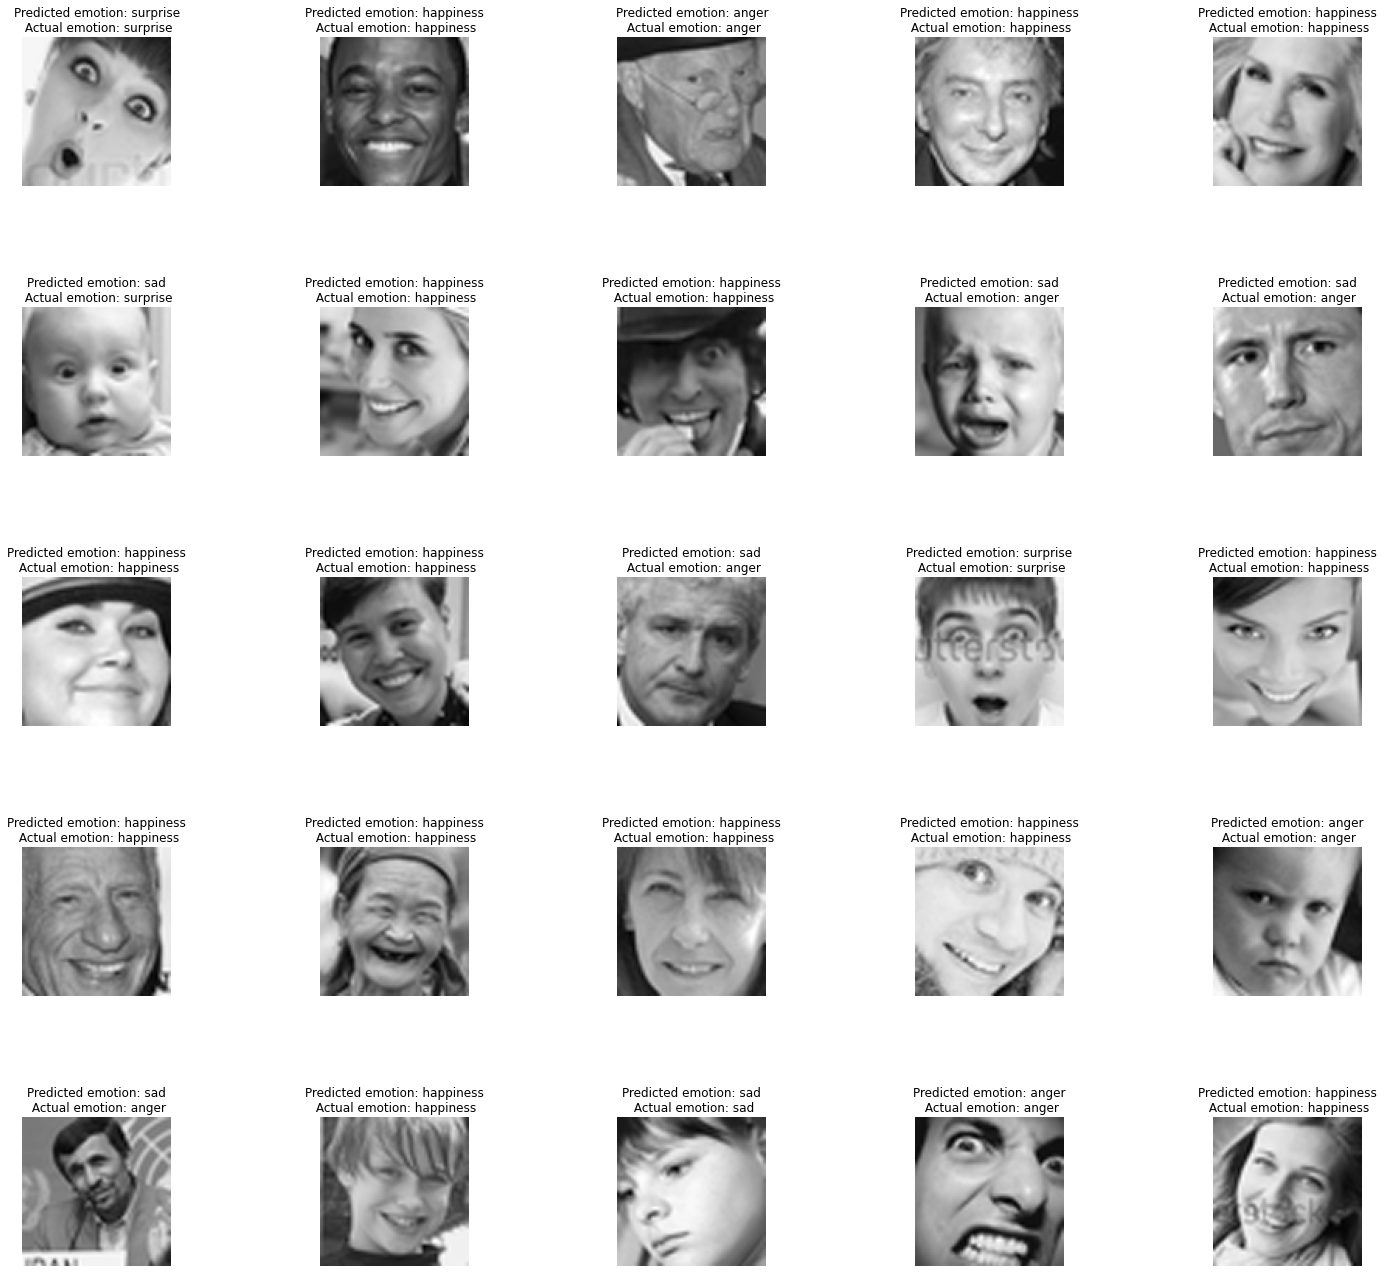

In [58]:
rows = 5
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(24, 24))
axes = axes.ravel()

for i in np.arange(0, rows*cols):
  axes[i].imshow(X_test[i].reshape(96, 96), cmap="gray")
  axes[i].set_title("Predicted emotion: {}\n Actual emotion: {}".format(label_to_text[pred_classes[i]], label_to_text[y_true[i]]))
  axes[i].axis("off")

plt.subplots_adjust(wspace=1)

##### Classification Report

In [61]:
print(classification_report(y_true, pred_classes))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       247
           1       0.60      0.30      0.40        30
           2       0.63      0.85      0.73       319
           3       0.92      0.84      0.87       433
           4       0.84      0.84      0.84       200

    accuracy                           0.76      1229
   macro avg       0.73      0.67      0.68      1229
weighted avg       0.77      0.76      0.76      1229

